<a href="https://colab.research.google.com/github/zacharylazzara/tent-detection/blob/main/UNet_Tent_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tent Detector
This notebook detects tents in satellite images using UNet. You can upload your own data and models under settings. The notebook supports running multiple models, each with multiple metrics, but this capability is not reflected in the settings at present.


---
Defaults used by the models (both uploaded and otherwise):
* Loss: `BCEWithLogitsLoss()`
* Optimizer: `Adam()`
* Metrics: `BinaryF1Score()` and `BinaryJaccardIndex()`

If you want to change these you'll have to do it manually; they are specified within the first 14 lines of the [main](#scrollTo=DNtiwVc4WGl6&line=1&uniqifier=1) function (at the time of writing).

#Initialize Notebook

Imports needed by settings and removal of Colab's `sample_data`.

---
*Contents: [Colab Imports](#scrollTo=smiYG2o0SD57&line=1&uniqifier=1), [Cleanup](#scrollTo=1yCUNKesMzh7&line=1&uniqifier=1)*

In [1]:
#@title Colab Imports
import os
from enum import Enum
from google.colab import drive
from google.colab import files
from google.colab import output
from google.colab import runtime

class IO_Format(str, Enum):
  pass

In [2]:
#@title Cleanup
%%bash
if [ -d 'sample_data' ]; then
  rm -r sample_data
fi

#Settings

If you set `DATA_SOURCE` to "upload", be sure to use pre-tiled data. The number of tiles is the resolution of the heatmap (so if you want a higher resolution heatmap, you'll need to provide smaller tiles). Furthermore, the number of tiles must be square, otherwise we'll have an error when producing the overviews. Also, take note of the `IMAGE_HEIGHT` and `IMAGE_WIDTH` in config; this is the size the tiles should be (it's 512x512 by default). However, you should be able to use tiles of a different size, but they will be resized to 512x512 (you'll need to train a new model if you want to change the default tile size). Finally, make sure the filenames of the tiles sort correctly before uploading them.

If the notebook hangs on the settings code block, it's probably waiting for you to upload flies.

---
*Contents: [Inputs](#scrollTo=9bxlrwmB8skc&uniqifier=1), [Models](#scrollTo=_g4q4wCWzQW_&uniqifier=1), [Output Format](#scrollTo=uMr1qOc3bzl3&uniqifier=1), [Output](#scrollTo=UFtVNiv06x_g&uniqifier=1), [Config](#scrollTo=Rxo20pIfzlxW&uniqifier=1), [Overrides](#scrollTo=JPn265JbTlUM&uniqifier=1)*

In [3]:
#@title Inputs
DATA_SOURCE = 'default' #@param ["default", "upload"]
ASSERT_DATA_IS_SQUARE = True # We can't change this setting without causing an error (leaving it in incase I address the error in the future)
#@markdown ---
USING_DEFAULT_DATASET = DATA_SOURCE == 'default'
uploaded_map_filename = None
if not USING_DEFAULT_DATASET:
  uploaded_data = files.upload()
  if uploaded_data == {}:
    raise Exception('No files uploaded!')
  for filename in uploaded_data.keys():
    uploaded_map_filename = filename

class I_Format(IO_Format):
  model = 'pth' #@param ["pth"] {allow-input: true}
  spreadsheet = 'csv' #@param ["csv"] {allow-input: true}
  image = 'png' #@param ["png", "jpg"] {allow-input: true}

In [4]:
#@title Models
DOWNLOAD_MODEL = True #@param {type:"boolean"}
UPLOAD_MODEL = False #@param {type:"boolean"}
REFRESH_MODEL_ON_RESTART = False #@param {type:"boolean"}
#@markdown ---
MODEL_NAME = 'UNet' #@param {type:"string"}
DOWNLOAD_MODEL_URL = 'https://github.com/zacharylazzara/tent-detection/raw/main/UNet.pth' #@param {type:"string"}
MODEL_FILENAME = f'{MODEL_NAME}.{I_Format.model}'

uploaded_files = None
if REFRESH_MODEL_ON_RESTART and (UPLOAD_MODEL or DOWNLOAD_MODEL):
  os.remove(MODEL_FILENAME)
if DOWNLOAD_MODEL and not (os.path.exists(MODEL_FILENAME)):
  !wget $DOWNLOAD_MODEL_URL
  if not (os.path.exists(MODEL_FILENAME)):
    raise Exception(f'File "{MODEL_FILENAME}" not found!')
else:
  if UPLOAD_MODEL and not (os.path.exists(MODEL_FILENAME)):
    uploaded_files = files.upload()
    for filename in uploaded_files.keys():
      print(f'Uploaded file "{filename}"')
      if filename != MODEL_FILENAME:
        raise Exception('Filename must match MODEL_FILENAME!')
  if UPLOAD_MODEL and uploaded_files == {}:
    raise Exception('No files uploaded!')

--2023-05-04 22:49:49--  https://github.com/zacharylazzara/tent-detection/raw/main/UNet.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zacharylazzara/tent-detection/main/UNet.pth [following]
--2023-05-04 22:49:49--  https://raw.githubusercontent.com/zacharylazzara/tent-detection/main/UNet.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 496811 (485K) [application/octet-stream]
Saving to: ‘UNet.pth’

UNet.pth            100%[===================>] 485.17K  --.-KB/s    in 0.005s  

2023-05-04 22:49:49 (95.2 MB/s) - ‘UNet.pth’ saved [496811/496811]



In [5]:
#@title Output Format
class O_Format(IO_Format):
  model = 'pth' #@param ["pth"] {allow-input: true}
  spreadsheet = 'csv' #@param ["csv"] {allow-input: true}
  image = 'png' #@param ["png", "jpg"] {allow-input: true}

In [6]:
#@title Output
SAVE_TO_GOOGLE_DRIVE = True #@param {type:"boolean"}
DOWNLOAD_OUTPUT = False #@param {type:"boolean"}
#@markdown ---
CONTINUE_ON_GOOGLE_DRIVE_ERROR = True #@param {type:"boolean"}
PLAY_SOUND_ON_COMPLETE = False #@param {type:"boolean"}
KILL_RUNTIME_ON_COMPLETE = True #@param {type:"boolean"}
MINUTES_TO_KILL_RUNTIME = 5 #@param {type:"slider", min:0, max:30, step:1}
MINUTES_TO_KILL_RUNTIME = MINUTES_TO_KILL_RUNTIME*60
#@markdown ---
DISPLAY_VISUALIZATIONS = True #@param {type:"boolean"}


In [7]:
#@title Config
TRAIN_MODEL = True #@param {type:"boolean"}
#@markdown ---
RESIZE_TILES = True #@param {type:"boolean"}
IMAGE_HEIGHT = 512 #@param {type:"number"}
IMAGE_WIDTH = 512 #@param {type:"number"}
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
#@markdown ---
N_EPOCHS = 200 #@param {type:"number"}
BATCH_SIZE = 8 #@param {type:"number"}
INIT_LR = 0.0001 #@param {type:"number"}
TEST_SPLIT = 0.2 #@param {type:"number"}
RANDOM_STATE = 42 #@param {type:"number"}

In [8]:
#@title Overrides
ALLOW_SETTINGS_OVERRIDE = True #@param {type:"boolean"}
TURN_OFF_WANDB_WARNINGS = True #@param {type:"boolean"}
DISABLE_TRAINING_ON_CPU = ALLOW_SETTINGS_OVERRIDE

if ALLOW_SETTINGS_OVERRIDE:
  print('Settings Override is enabled')
  # If we download/upload the model we don't need to train it
  if DOWNLOAD_MODEL or UPLOAD_MODEL:
    TRAIN_MODEL = False
    print('Disabled TRAIN_MODEL')

  # No need to download if we're saving to Google Drive
  if SAVE_TO_GOOGLE_DRIVE:
    DOWNLOAD_OUTPUT = False
    print('Disabled DOWNLOAD_OUTPUT')

  # Killing the runtime on complete is only useful if we save the data somewhere first
  if not DOWNLOAD_OUTPUT:
    MINUTES_TO_KILL_RUNTIME = 0
    print(f'Set MINUTES_TO_KILL_RUNTIME to {MINUTES_TO_KILL_RUNTIME}')
    if not SAVE_TO_GOOGLE_DRIVE:
      KILL_RUNTIME_ON_COMPLETE = False
      print('Disabled KILL_RUNTIME_ON_COMPLETE')

if TURN_OFF_WANDB_WARNINGS:
  # Turning off warnings as there seems to be a bug in
  # wandb https://github.com/wandb/wandb/issues/1994
  os.environ['WANDB_CONSOLE'] = 'off'
  print('Disabled WandB Warnings')

Settings Override is enabled
Disabled TRAIN_MODEL
Set MINUTES_TO_KILL_RUNTIME to 0
Disabled KILL_RUNTIME_ON_COMPLETE
Disabled WandB Warnings


#Definitions

The primary logic.

---
*Contents: [Initialization](#scrollTo=7Vfi33_GtEj2&uniqifier=1), [Models](#scrollTo=QMaVfs-TuId3&uniqifier=1), [Functions](#scrollTo=m5vpYefL-2Cx&uniqifier=1)*

##Initialization

All the environment setup for the notebook.

---
*Contents: [Imports](#scrollTo=PMBNizBrtJZS&line=1&uniqifier=1), [Device](#scrollTo=yI4mFY9uMosP&line=1&uniqifier=1), [Paths](#scrollTo=vorAQM6jtdOu&line=1&uniqifier=1), [Mount](#scrollTo=8yL4WjAfIOeb&line=1&uniqifier=1), [Environment](#scrollTo=NMzegdPaUd7Q&line=1&uniqifier=1)*

In [9]:
#@title Imports
!pip install -q tqdm-thread
!pip install -q torchmetrics
import time
import math
import csv
import cv2
import torch
import threading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms.functional as TF
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from statistics import mean
from tqdm.auto import tqdm
from tqdm_thread import tqdm_thread
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import Sequential
from torch.nn import ModuleList
from torch.nn import ConvTranspose2d
from torch.nn import Flatten
from torch.nn import functional
from torch.nn import BatchNorm2d
from torch.nn import Softplus
from torch.nn.modules.loss import BCEWithLogitsLoss
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.classification import BinaryF1Score
from torch import flatten
from torch import cat
from torch import randn
from torchvision import transforms
from torchvision.transforms import CenterCrop
from torchvision.utils import save_image
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import SGD

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.2 MB/s eta 0:00:00


In [10]:
#@title Device
DEVICE = None
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
PIN_MEMORY = True if DEVICE != 'cpu' else False
print(f'Using device: {DEVICE}')

if DISABLE_TRAINING_ON_CPU:
  TRAIN_MODEL = TRAIN_MODEL if DEVICE != 'cpu' else False
  print('Warning: Training on CPU is disabled!')

Using device: cpu


In [11]:
#@title Paths
OUTPUT_PATH         = os.environ['OUTPUT_PATH']         = f'output'
Y_PATH              = os.environ['Y_PATH']              = f'{OUTPUT_PATH}/truths'
P_PATH              = os.environ['P_PATH']              = f'{OUTPUT_PATH}/predictions'

# Default Dataset Paths
SRC_PATH            = os.environ['SRC_PATH']            = f'sarpol-zahab-tents'
DATA_PATH           = os.environ['DATA_PATH']           = f'{SRC_PATH}/data'
IMAGES_PATH         = os.environ['IMAGES_PATH']         = f'{DATA_PATH}/images'
MASKS_PATH          = os.environ['MASKS_PATH']          = f'{DATA_PATH}/labels'
LABELS_PATH         = os.environ['LABELS_PATH']         = f'{DATA_PATH}/sarpol_counts.csv'

# Google Drive Paths
G_DRIVE_MOUNT_POINT = os.environ['G_DRIVE_MOUNT_POINT'] = f'g_drive'
G_DRIVE_STORAGE     = os.environ['G_DRIVE_STORAGE']     = f'{G_DRIVE_MOUNT_POINT}/MyDrive'

In [12]:
#@title Mount
if SAVE_TO_GOOGLE_DRIVE:
  if not os.path.exists(G_DRIVE_MOUNT_POINT):
    os.makedirs(G_DRIVE_MOUNT_POINT)
  try:
    drive.mount(G_DRIVE_MOUNT_POINT)
  except Exception as err:
    SAVE_TO_GOOGLE_DRIVE = False
    KILL_RUNTIME_ON_COMPLETE = False
    if not CONTINUE_ON_GOOGLE_DRIVE_ERROR:
      print(f'Unable to mount Google Drive!\n{err}')
      raise
    else:
      print('Warning: Unable to mount Google Drive, data will not be copied and must be downloaded manually!')
  else:
    print(f'Mounted Google Drive to {G_DRIVE_MOUNT_POINT}')

In [13]:
#@title Environment
if not os.path.exists(SRC_PATH) and USING_DEFAULT_DATASET:
  !git clone https://github.com/tofighi/sarpol-zahab-tents.git
if not os.path.exists(OUTPUT_PATH):
  os.makedirs(OUTPUT_PATH)

Cloning into 'sarpol-zahab-tents'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (332/332), done.
remote: Total 383 (delta 54), reused 367 (delta 49), pack-reused 0
Receiving objects: 100% (383/383), 14.33 MiB | 15.12 MiB/s, done.
Resolving deltas: 100% (54/54), done.


##Models

All the classes used in the notebook.

---
*Contents: [UNet](#scrollTo=2IeM8zsTBq5d&line=1&uniqifier=1), [Dataset](#scrollTo=U00pSVfc0M4f&line=1&uniqifier=1), [Model](#scrollTo=zhQM-Oq8fWS5&line=1&uniqifier=1), [Visualizations](#scrollTo=y2Ts2LPnGt2K&line=1&uniqifier=1)*

In [14]:
#@title UNet
# Adapted from: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
class Block(Module):
  def __init__(self, in_channels, out_channels):
    super(Block, self).__init__()
    self.double_conv2d = Sequential(
        Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        BatchNorm2d(out_channels),
        ReLU(inplace=True),
        Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        BatchNorm2d(out_channels),
        ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv2d(x)

class Encoder(Module):
  def __init__(self, channels=(3, 16, 32, 64)):
    super(Encoder, self).__init__()
    self.encoder_blocks = ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels)-1)])
    self.pool = MaxPool2d(2)

  def forward(self, x):
    block_outputs = []
    for block in self.encoder_blocks:
      x = block(x)
      block_outputs.append(x)
      x = self.pool(x)
    return block_outputs

class Decoder(Module):
  def __init__(self, channels=(64, 32, 16)):
    super(Decoder, self).__init__()
    self.up_convs = ModuleList([ConvTranspose2d(channels[i], channels[i+1], 2, 2) for i in range(len(channels)-1)])
    self.decoder_blocks = ModuleList([Block(channels[i], channels[i+1]) for i in range(len(channels)-1)])
  
  def crop(self, encoder_features, x):
    (_, _, H, W) = x.shape
    return CenterCrop([H, W])(encoder_features)
  
  def forward(self, x, encoder_features):
    for i in range(len(self.up_convs)):
      x = self.up_convs[i](x)
      encoder_feature = self.crop(encoder_features[i], x)
      x = cat([x, encoder_feature], dim=1)
      x = self.decoder_blocks[i](x)
    return x

class UNet(Module):
  def __str__(self) -> str:
    return 'UNet'

  def __init__(self, encoder_channels=(3, 16, 32, 64), decoder_channels=(64, 32, 16), classes=1, retain_dim=True, output_size=(512, 512)):
    super(UNet, self).__init__()
    self.encoder = Encoder(encoder_channels)
    self.decoder = Decoder(decoder_channels)
    self.head = Conv2d(decoder_channels[-1], classes, 1)
    self.retain_dim = retain_dim
    self.output_size = output_size

  def forward(self, x):
    encoder_features = self.encoder(x)
    decoder_features = self.decoder(encoder_features[::-1][0], encoder_features[::-1][1:])
    map = self.head(decoder_features)
    if self.retain_dim:
      map = functional.interpolate(map, self.output_size)
    return map

In [15]:
#@title Dataset
# Adapted from: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
class SegmentationDataset(Dataset):
  def __init__(self, dataframe, transformations = None):
    self.dataframe = dataframe
    self.transformations = transformations

  def __len__(self):
    return len(self.dataframe.index)

  def __getitem__(self, index):
    """
    If there's no mask path, generate a blank mask. This is for the case where
    we only want to perform predictions and as such haven't included any masks.
    Works as expected when mask paths are included.
    """
    image_paths = self.dataframe.iloc[index]['image_paths']
    mask_paths = self.dataframe.iloc[index]['mask_paths']
    image = cv2.cvtColor(cv2.imread(image_paths), cv2.COLOR_BGR2RGB)
    mask = None
    if mask_paths:
      mask = cv2.threshold(cv2.imread(mask_paths, cv2.IMREAD_GRAYSCALE), 150, 255, cv2.THRESH_BINARY)[1]
    else:
      mask = cv2.threshold(np.zeros((image.shape[0], image.shape[1], 1), dtype=np.uint8), 150, 255, cv2.THRESH_BINARY)[1]
    if self.transformations:
      image = self.transformations(image)
      mask = self.transformations(mask)
    return (image, mask, self.dataframe.iloc[index]['labels'], self.dataframe.index[index])

In [16]:
#@title Model
class Model():
  """Makes it possible to work with models in a more generalized and scalable fashion."""

  def __init__(self, root_directory:str, model, loss_fn, opt_fn, metric_fns=None, **kwargs) -> None:
    self.device = kwargs.get('device', DEVICE)
    self.model = model.to(self.device)
    self.loss_fn = loss_fn
    self.opt_fn = opt_fn(self.model.parameters(), lr=kwargs.get('lr', INIT_LR))
    self.metric_fns = metric_fns
    self.format = kwargs.get('format', O_Format)
    self.dirs = make_directories({'output':       f'{root_directory}', 
                                  'predictions':  f'{root_directory}/tiles', 
                                  'history':      f'{root_directory}/metrics'})

    # TODO: handle the case when metrics is none (it might break history); might
    # want to do the same with loss if we're not interested in training a new model.
    self.history = {
        't': {str(key):value for (key, value) in zip(['losses', *self.metric_fns], [[] for _ in [*self.metric_fns, '']])},
        'v': {str(key):value for (key, value) in zip(['losses', *self.metric_fns], [[] for _ in [*self.metric_fns, '']])}}
  
  def __str__(self) -> str:
    return str(self.model)

  def train(self, t_loader:DataLoader, v_loader:DataLoader, epochs:int, pbar:tqdm=None, **kwargs) -> pd.DataFrame:
    """Trains the model."""
    if self.metric_fns:
      for metric_fn in self.metric_fns:
        metric_fn.to(self.device)

    if pbar:
      pbar = pbar(range(epochs))
      pbar.set_description(f'Training {self.model}')
    for e in pbar if pbar else range(epochs):
      self.model.train()
      losses = []
      for (i, (x, y, _, _)) in enumerate(t_loader):
        (x, y) = (x.to(self.device), y.to(self.device))

        pred = self.model(x)
        loss = self.loss_fn(pred, y)
        losses.append(loss.item())

        if loss.requires_grad:
          self.opt_fn.zero_grad()
          loss.backward()
        self.opt_fn.step()

        if self.metric_fns:
          for metric_fn in self.metric_fns:
            metric_fn.update(pred, y)
          
      self.history['t']['losses'].append(mean(losses))
      if self.metric_fns:
        for metric_fn in self.metric_fns:
          self.history['t'][f'{metric_fn}'].append(metric_fn.compute().cpu().detach().numpy().item())
          metric_fn.reset()
      
      # Append the prediction metrics into history. We might not actually need a lambda for this.
      [(lambda k, v: [self.history['v'][k].append(p) for p in v])(k, v) for k, v in self.predict(v_loader)[2].items()]

      if pbar:
        pbar.set_description(f'Epoch({e+1}/{epochs}) Training {self.model}, Training Loss: {self.history["t"]["losses"][-1]:.4f}, Validation Loss: {self.history["v"]["losses"][-1]:.4f}')

    if kwargs.get('save_model'): self.save_model()
    if kwargs.get('save_history'): self.save_training_history()
    return pd.DataFrame(self.history).fillna(np.nan)

  def predict(self, loader:DataLoader, pbar:tqdm=None, save_predictions:bool=False) -> tuple[list, pd.DataFrame | None, pd.DataFrame]:
    """Evaluates the model."""
    history = {str(key):value for (key, value) in zip(['losses', *self.metric_fns], [[] for _ in [*self.metric_fns, '']])}
    predictions = []
    with torch.no_grad():
      self.model.eval()
      
      losses = []
      if pbar:
        pbar = pbar(loader)
        pbar.set_description(f'Evaluating {self.model}')
      for (x, y, _, name) in pbar if pbar else loader:
        (x, y) = (x.to(self.device), y.to(self.device))
        p = self.model(x)

        if self.loss_fn:
          loss = self.loss_fn(p, y)
          losses.append(loss.item())
        if self.metric_fns:
          for metric_fn in self.metric_fns:
            metric_fn.update(p, y)

        for batch, mask in enumerate(p.cpu().detach()):
          predictions.append({'name':name[batch], 'mask': mask})

      if losses != []:
        history['losses'].append(mean(losses))
      if self.metric_fns:
        for metric_fn in self.metric_fns:
          history[f'{metric_fn}'].append(metric_fn.compute().cpu().detach().numpy().item())
          metric_fn.reset()

    return predictions, self.__save_predictions(predictions) if save_predictions else None, pd.DataFrame(history).fillna(np.nan)

  def __save_predictions(self, predictions:list, **kwargs) -> pd.DataFrame:
    """Saves predictions to disk and outputs a dataframe with the names, paths, and labels."""
    saved_predictions = []
    for prediction in predictions:
      out_path = f'{kwargs.get("directory_override", self.dirs.predictions)}/{prediction["name"]}.{kwargs.get("format_override", self.format.image)}'
      save_image(prediction['mask'], out_path)
      saved_predictions.append({'names':prediction["name"], 
                                'image_paths': None,
                                'mask_paths':out_path, 
                                'labels':self.__count_contours(prediction['mask'])})
    return pd.DataFrame(saved_predictions).set_index('names').fillna(np.nan)

  # TODO: either remove save_predictions_to_spreadsheet or set it up so we call it from __save_predictions
  # def save_predictions_to_spreadsheet(self, predictions_dataframe, **kwargs):
  #   output_path = f'{kwargs.get("directory_override", self.dirs.predictions)}/{kwargs.get("filename_override", f"labels.{self.format.spreadsheet}")}'
  #   predictions_dataframe.to_csv(output_path)
  #   return output_path

  def save_model(self, **kwargs) -> None:
    if kwargs.get('state_dict', True):
      torch.save(self.model.state_dict(), f'{kwargs.get("directory_override", self.dirs.output)}/{kwargs.get("filename_override", f"{self.model}.{self.format.model}")}')
    else:
      torch.save(self.model, f'{kwargs.get("directory_override", self.dirs.output)}/{kwargs.get("filename_override", f"{self.model}.{self.format.model}")}')

  def save_training_history(self) -> tuple[str, list]:
    """Saves training history (loss and metric values per epoch) to disk."""
    model_name = str(self.model).replace('()', '')
    loss_fn_name = str(self.loss_fn).replace('()', '')
    loss_output_path = f'{self.dirs.history}/{model_name}_loss_{loss_fn_name}.{self.format.image}'
    metric_output_paths = []

    # Loss
    plt.plot(self.history['t']['losses'], label='training')
    plt.plot(self.history['v']['losses'], label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Loss ({loss_fn_name})')
    plt.savefig(loss_output_path)

    # Cleanup
    plt.clf()
    plt.cla()
    plt.close()

    # Metrics
    if self.metric_fns: # TODO: just iterate through self.history instead
      for metric_fn in self.metric_fns:
        metric_fn_name = str(metric_fn).replace('()', '')
        metric_output_path = f'{self.dirs.history}/{model_name}_metric_{metric_fn_name}.{self.format.image}'

        plt.plot(self.history['t'][f'{metric_fn}'], label='training')
        plt.plot(self.history['v'][f'{metric_fn}'], label='validation')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')
        plt.title(f'{model_name} Metric ({metric_fn_name})')
        plt.savefig(metric_output_path)

        # Cleanup
        plt.clf()
        plt.cla()
        plt.close()

        metric_output_paths.append(metric_output_path)
    
    return loss_output_path, metric_output_paths

  def __save_prediction_performance(self, p_performance) -> str:
    """Saves the loss and metrics of the prediction if applicable."""
    model_name = str(self.model).replace('()', '')
    output_path = f'{self.dirs.history}/{model_name}_performance.{self.format.image}'
    bar_data = {}
    if self.loss_fn:
      bar_data[str(self.loss_fn).replace('()', '')] = mean(p_performance['losses'])
    if self.metric_fns:
      for metric_fn in self.metric_fns:
        bar_data[str(metric_fn).replace('()', '')] = mean(p_performance[f'{metric_fn}'])
    if bar_data:
      plt.bar(list(bar_data.keys()), list(bar_data.values()))
      plt.ylim([0, 1])
      plt.title(f'{model_name} Mean Performance')
      plt.savefig(output_path)
      plt.close()
    return output_path

  def __contours(self, p) -> list:
    """Used to locate blobs in the prediction that correspond to tents."""
    # Adapted from https://stackoverflow.com/questions/48154642/how-to-count-number-of-dots-in-an-image-using-python-and-opencv
    img = p.numpy().T.astype(np.uint8).copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    cnts = cv2.findContours(closing, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]
    max_area = 20
    xcnts = []
    for cnt in cnts:
      if cv2.contourArea(cnt) < max_area:
        xcnts.append(cnt)
    return xcnts

  def __count_contours(self, p) -> int:
    """Count the number of blobs in the prediction mask (i.e., number of tents)"""
    return int(len(self.__contours(p)))

In [17]:
#@title Visualizations
class Visualizations():
  """Allows us to work with the images while ensuring we stay in the right directory."""
  def __init__(self, root_directory:str, format:O_Format=O_Format) -> None:
    self.format = format
    self.dirs = make_directories({'output'    :f'{root_directory}',
                                  'tiles'     :f'{root_directory}/tiles',
                                  't_overlay' :f'{root_directory}/tiles/overlay'})

  def merge(self, tiles:torch.Tensor, tile_row) -> torch.Tensor:
    """Merges a row of tiles. The total number of tiles must be divisible by 2."""
    if tiles == None:
      tiles = torch.cat(tuple(tile_row), 2)
    else:
      tiles = torch.cat((tiles, torch.cat(tuple(tile_row), 2)), 1)
    return tiles
  
  def tile(self, loader:DataLoader, output_name_x:str, output_name_y:str, pbar:tqdm=None) -> tuple[str, str]:
    """Tiles using a loader. Total number of tiles must be divisible by 2."""
    output_path_x = output_path_y = ''
    output_x = output_y = None

    if pbar:
      pbar = pbar(loader)
      pbar.set_description(f'Tiling')
    for (x, y, _, _) in pbar if pbar else loader:
      if output_name_x:
        output_x = self.merge(output_x, x)
      if output_name_y:
        output_y = self.merge(output_y, y)
    
    if output_x is not None:
      output_path_x = f'{self.dirs.output}/{output_name_x}.{self.format.image}'
      save_image(output_x, output_path_x)
    if output_y is not None:
      output_path_y = f'{self.dirs.output}/{output_name_y}.{self.format.image}'
      save_image(output_y, output_path_y)
    
    return output_path_x, output_path_y
  
  def overlay_from_path(self, background_path:str, foreground_path:str, bg_opacity:float=1, fg_opacity:float=1):
    with Image.open(background_path).convert('RGB') as background_image:
      background_image = background_image
    with Image.open(foreground_path).convert('RGB') as foreground_image:
      foreground_image = foreground_image
    return self.overlay_image(background_image, foreground_image, bg_opacity, fg_opacity)
  
  def save_overlay_from_path(self, background_path:str, foreground_path:str, output_name, bg_opacity:float=1, fg_opacity:float=1, tile:bool=False):
    return self.save_overlay(self.overlay_from_path(background_path, foreground_path, bg_opacity, fg_opacity), output_name, tile)
  
  def overlay_image(self, background_image, foreground_image, bg_opacity:float=1, fg_opacity:float=1):
    foreground_image = np.array(foreground_image.resize(background_image.size)) # Make sure foreground image matches background image size
    background_image = np.array(background_image)

    for channel in range(1, 2):
      foreground_image[foreground_image[:,:,channel] > 0, channel] = 0
      
    overlay = cv2.addWeighted(background_image, bg_opacity, foreground_image, fg_opacity, 0)
    return Image.fromarray(overlay)

  def save_overlay(self, overlayed_image:Image, output_name:str, tile:bool=False):
    output_path = f'{self.dirs.t_overlay if tile else self.dirs.output}/{output_name}.{self.format.image}'
    overlayed_image.save(output_path)
    return output_path

  def save_heatmap(self, image_path:str, dataframe:pd.DataFrame, output_name:str, title:str):
    data = [x for x in np.array_split(dataframe['labels'].replace(0, np.nan).tolist(), int(math.sqrt(dataframe.shape[0])))]

    sns.set(font_scale=1)
    _, ax = plt.subplots(figsize=(15, 15))
    ax.set_title(title)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.tick_params(left=False, bottom=False)
    sns.heatmap(data, annot=True, square=True, fmt='.5g', alpha=0.3, zorder=2, cbar_kws={'shrink': 0.7}, ax=ax)

    with Image.open(image_path).convert("RGB") as image:
      ax.imshow(image, aspect=ax.get_aspect(), extent=ax.get_xlim()+ax.get_ylim(), zorder=1)

    output_path = f'{self.dirs.output}/{output_name}.{self.format.image}'

    plt.savefig(output_path, bbox_inches='tight')
    
    # Cleanup
    plt.clf()
    plt.cla()
    plt.close()

    return output_path

  def region_box(self, name:str, c:int, w:int, h:int):
    """Draws the region box with the tent count and name."""
    shape = [(0, 0), (w-1, h-1)]
    
    img = Image.new('RGBA', (w, h))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('LiberationMono-Regular.ttf', 50)
    draw.text((10, 10), f'{c}', font=font, fill=(255, 0, 0))

    _, _, tw, th = draw.textbbox((0, 0), name, font=font)

    tw = w-tw
    th = h-th

    draw.text((tw-20, th-10), name, font=font, fill=(255, 0, 0))

    rec = ImageDraw.Draw(img)  
    rec.rectangle(shape, fill = None, outline ='red')

    return img

  def save_region(self, loader:DataLoader, overview_path:str):
    """
    Generates an outline around each image and puts the number of tents
    in the upper left corner of the image, with the image name in the bottom right.
    Mostly redundant since we're using Seaborn for the heatmap anyway, but may
    be useful for troubleshooting.
    """
    region_paths = []
    pbar = tqdm(loader)
    pbar.set_description(f'Creating region overlays...')
    region_overview = None
    for (_, y, c, name) in pbar:
      regions = []
      for batch, img in enumerate(y.cpu().detach()):
        out_path = f'{self.dirs.output}/{name[batch]}.{format.image}'
        region = self.region_box(name[batch], c[batch], img.shape[1], img.shape[2])
        region.save(out_path)
        region_paths.append({'names':name[batch], 'region_paths':out_path})
        pbar.set_description(f'Saved region overlay for {name[batch]} to {out_path}')

        transform = transforms.Compose([transforms.PILToTensor()])
        region = transform(region)
        regions.append(region)

      region_overview = self.merge(region_overview, regions).double()
    save_image(region_overview, overview_path)
    return pd.DataFrame(region_paths).set_index('names').fillna(np.nan)

##Functions

All the functions used in the notebook.

---
*Contents: [Load](#scrollTo=1bhM-gJ8uLKN&line=1&uniqifier=1), [Make Directories](#scrollTo=tpzX4vj8mNzj&line=1&uniqifier=1), [Save Data](#scrollTo=q18yjjSfS8ya&line=1&uniqifier=1), [Evaluator](#scrollTo=TJ2eEW-qy8Du&line=1&uniqifier=1)*

In [18]:
#@title Load
def load_data(x_images_path:str=IMAGES_PATH, y_masks_path:str=MASKS_PATH, **kwargs) -> pd.DataFrame:
  if kwargs.get('directory'):
    return d_data(kwargs.get('directory'), y_masks_path, **kwargs)
  else:
    return c_data(x_images_path, y_masks_path, kwargs.get('csv_path', LABELS_PATH), **kwargs)

def c_data(x_images_path:str, y_masks_path:str, csv_path:str, **kwargs) -> pd.DataFrame:
  return associate_data(x_images_path, y_masks_path, csv_data(csv_path, **kwargs), **kwargs)

def d_data(x_images_path:str, y_masks_path:str=None, **kwargs) -> pd.DataFrame:
  return associate_data(x_images_path, y_masks_path, directory_data(x_images_path, kwargs.get('format', I_Format)), **kwargs)

def associate_data(x_images_path:str, y_masks_path:str, rows:list, **kwargs) -> pd.DataFrame:
  """
  Returns a dataframe with the feature and target paths, along with the image
  name and number of tents (i.e., labels).
  """
  if kwargs.get('assert_square', True): assert len(rows) % 2 == 0, f'Number of rows ({len(rows)}) are not even!'
  return pd.DataFrame({
    'names'        : [row[0].split('.')[0] for row in rows],
    'image_paths'  : [str(next(Path(x_images_path).glob(row[0]))) if x_images_path else None for row in rows],
    'mask_paths'   : [str(next(Path(y_masks_path).glob(row[0]))) if y_masks_path else None for row in rows],
    'labels'       : [int(row[1]) for row in rows]
  }).set_index('names').astype({'labels': 'int'})

def csv_data(csv_path, **kwargs) -> list[tuple[str, int]]:
  rows = pd.read_csv(csv_path, header=kwargs.get('header'))
  return list(rows.itertuples(index=False, name=None))

def directory_data(directory:str, format:I_Format) -> list[tuple[str, int]]:
  names = []
  for filepath in Path(directory).glob(f'*.{format.image}'):
    names.append((filepath.name, -1))
  return names

In [19]:
#@title Make Directories
def make_directories(directories:dict[str,str]) -> Enum:
  for directory in directories.values():
    if not os.path.exists(directory):
      os.makedirs(directory)
  return Enum('Directories', directories, type=str)

In [20]:
#@title Save Data
def save_data(output_dir, data, transformations, pbar=None, **kwargs):
  dataset = SegmentationDataset(data, transformations)
  loader = DataLoader(dataset, shuffle=False, batch_size=int(math.sqrt(len(dataset))), pin_memory=PIN_MEMORY, num_workers=os.cpu_count(), persistent_workers=True)
  vis = Visualizations(output_dir, kwargs.get('format', O_Format))

  y = kwargs.get('y', 'y')

  print('Saving overviews...')
  x_overview_path, y_overview_path = vis.tile(loader,
                                              kwargs.get('x_overview_name', 'x_overview' if not kwargs.get('x_overview_path') else None),
                                              f'{y}_overview',
                                              pbar)
  x_overview_path = kwargs.get('x_overview_path', x_overview_path)

  overlay_path = heatmap_path = None
  if x_overview_path:
    print('Saving overlays...')
    np.vectorize(vis.save_overlay_from_path)(data['image_paths'], data['mask_paths'], np.vectorize((lambda n: n))(data.index), 0.7, tile=True)
    
    print('Saving overview overlay...')
    overlay_path = vis.save_overlay_from_path(x_overview_path, y_overview_path, f'{y}_overlay', 0.7)

    print('Saving heatmap...')
    heatmap_path = vis.save_heatmap(overlay_path, data, f'{y}_heatmap', kwargs.get('heatmap_title', 'Number of Tents per Region'))

    print('Done.')
  return {'x_overview_path': x_overview_path,
          'y_overview_path': y_overview_path,
          'overlay_path': overlay_path,
          'heatmap_path': heatmap_path}

In [21]:
#@title Evaluator
def evaluator(models:list, data:pd.DataFrame, transformations, train:bool=TRAIN_MODEL, **kwargs) -> None:
  dataset = SegmentationDataset(data, transformations)
  row_size = int(math.sqrt(len(dataset)))
  if row_size < 1:
    raise Exception("Dataset contains no data. Make sure you set the input format to the correct format!")
  loader = DataLoader(dataset, shuffle=False, batch_size=row_size, pin_memory=PIN_MEMORY, num_workers=os.cpu_count(), persistent_workers=True)

  paths = {}
  for model in models:
    if train:
      model.train(t_loader, v_loader, N_EPOCHS, tqdm, save_model=True, save_history=True)
    p_data = model.predict(loader, tqdm, save_predictions=True)[1].combine_first(data).sort_index() # Fill in the missing feature paths while preserving the prediction paths
    paths[str(model)] = save_data(P_PATH, p_data, transformations, tqdm, y='p', heatmap_title='Detected Tents per Region', **kwargs)

  return paths

#Output
Output will be saved to Colab's default directory (`/content`). When computation is complete, the output will be compressed as a zip file. If Google Drive is connected, the zip file will be copied to the root of your Google Drive with the filename "`tent_detector_output.zip`".

---
*Contents: [Main](#scrollTo=DNtiwVc4WGl6&line=1&uniqifier=1), [Display Heatmap](#scrollTo=9eSPRdD646oW&line=1&uniqifier=1), [Complete](#scrollTo=F3e0Itqf4_Uh&line=1&uniqifier=1)*

In [39]:
#@title Main
models = []
if UPLOAD_MODEL or DOWNLOAD_MODEL:
  model = None
  checkpoint = torch.load(MODEL_FILENAME, map_location=DEVICE)
  
  try:
    checkpoint.eval()
  except AttributeError:
    print('Loading checkpoint')
    model = UNet()
    model.load_state_dict(checkpoint)
  else:
    print('Loading model')
    model = checkpoint

  models.append(Model(P_PATH,
                      model,
                      BCEWithLogitsLoss(),
                      Adam,
                      [BinaryF1Score(), BinaryJaccardIndex()]))
else:
  models.append(Model(P_PATH,
                      UNet(),
                      BCEWithLogitsLoss(),
                      Adam,
                      [BinaryF1Score(), BinaryJaccardIndex()]))

trans_settings = [transforms.ToPILImage(), transforms.ToTensor()]
if RESIZE_TILES:
  trans_settings.append(transforms.Resize(IMAGE_SIZE, antialias=True))
transformations = transforms.Compose(trans_settings)

results = None
if USING_DEFAULT_DATASET:
  y_data = load_data()

  training_data, validation_data = train_test_split(y_data, test_size=TEST_SPLIT, random_state=RANDOM_STATE)
  training_dataset = SegmentationDataset(training_data, transformations)
  validation_dataset = SegmentationDataset(validation_data, transformations)

  t_loader = DataLoader(training_dataset, shuffle=True, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=os.cpu_count(), persistent_workers=True)
  v_loader = DataLoader(validation_dataset, shuffle=True, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=os.cpu_count(), persistent_workers=True)

  t_count = len(training_data)
  v_count = len(validation_data)

  t_ratio = 1-v_count/t_count
  v_ratio = v_count/t_count

  print(f'Training to Validation Ratio\n')
  print(f'Training ({t_count}): \t{t_ratio*100:>10.2f}%')
  print(f'Validation ({v_count}): \t{v_ratio*100:>10.2f}%')
  print(f'Total ({t_count + v_count}): \t\t{t_ratio*100 + v_ratio*100:>10.2f}%\n') 

  assert t_ratio + v_ratio == 1 # Sanity Check

  gt_paths = save_data(Y_PATH, y_data, transformations, tqdm, heatmap_title='Actual Tents per Region')
  results = evaluator(models, y_data, transformations, x_overview_path=gt_paths['x_overview_path'])
else:
  results = evaluator(models, load_data(directory='.', y_masks_path=None, assert_square=ASSERT_DATA_IS_SQUARE), transformations, train=False)

Loading checkpoint
Training to Validation Ratio

Training (204): 	     74.51%
Validation (52): 	     25.49%
Total (256): 		    100.00%

Saving overviews...


  0%|          | 0/16 [00:00<?, ?it/s]

Saving overlays...
Saving overview overlay...
Saving heatmap...
Done.


  0%|          | 0/16 [00:00<?, ?it/s]

Saving overviews...


  0%|          | 0/16 [00:00<?, ?it/s]

Saving overlays...
Saving overview overlay...
Saving heatmap...
Done.


Displaying UNet Heatmap (output/predictions/p_heatmap.png)


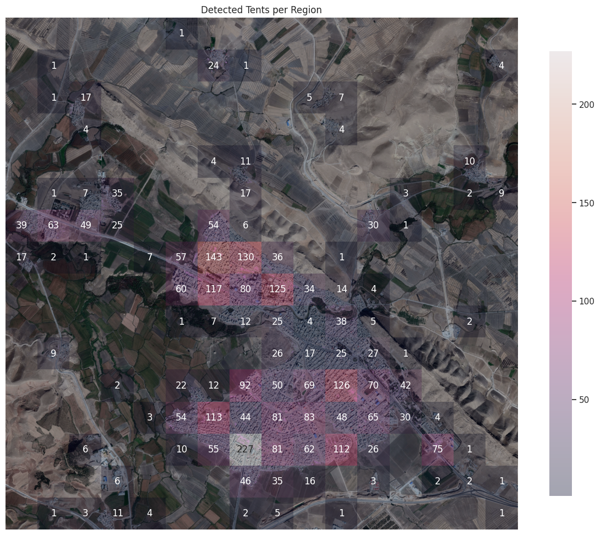

In [40]:
#@title Display Heatmap
if DISPLAY_VISUALIZATIONS:
  for modelname, result in results.items():
    print(f'Displaying {modelname} Heatmap ({result["heatmap_path"]})')
    with Image.open(result['heatmap_path']) as image:
      image.thumbnail((600, 600))
      image.show()
    print('\n\n')

In [41]:
#@title Complete

# Since there's seemingly no way to reasonably wait for files.download, we have
# to wait a specified period of time before disconnecting the session. This only
# applies when we trigger a browser download; copying files to Google Drive can
# be done in a blocking way (thus this is the preferred method).

def kill_runtime(seconds):
  with tqdm_thread(desc='Terminating session...', total=seconds, step_sec=0.5):
    time.sleep(seconds)
  print('Session terminated automatically.')
  time.sleep(1)
  runtime.unassign()

def end_runtime(seconds):
  if seconds > 0:
    print(f'Terminating Session in {seconds//60} minutes...')
    threading.Thread(target=kill_runtime, args=[seconds]).start()
  else:
    print('Session terminated automatically.')
    time.sleep(1)
    runtime.unassign()

print(f'Zipping output and finishing up.')
!7z a -tzip tent_detector_output.zip $OUTPUT_PATH

if SAVE_TO_GOOGLE_DRIVE:
  print('\nSaving to Google Drive\n')
  !rsync -arh --progress tent_detector_output.zip $G_DRIVE_STORAGE
if DOWNLOAD_OUTPUT:
  print('\nDownloading to Local Storage\n')
  files.download('tent_detector_output.zip')
if PLAY_SOUND_ON_COMPLETE:
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
print('Done.\n\n')
if KILL_RUNTIME_ON_COMPLETE:
  end_runtime(MINUTES_TO_KILL_RUNTIME)

Zipping output and finishing up.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive:
  0M Scan           8 folders, 775 files, 464447032 bytes (443 MiB)

Creating archive: tent_detector_output.zip

Items to compress: 783

  0%      0% 3 + output/predictions/p_overview.png                                            1% 9 + output/predictions/tiles/overlay/sarpol_006.png                                                          2% 18 + output/predictions/tiles/overlay/sarpol_015.png                                                         